Using device: cuda

Training ANN Model...
Epoch [1/65] | Train Loss: 0.5823 | Val Loss: 0.4203 | Val Acc: 84.88%
Epoch [2/65] | Train Loss: 0.4251 | Val Loss: 0.4171 | Val Acc: 84.44%
Epoch [3/65] | Train Loss: 0.3943 | Val Loss: 0.3725 | Val Acc: 86.61%
Epoch [4/65] | Train Loss: 0.3706 | Val Loss: 0.3640 | Val Acc: 86.62%
Epoch [5/65] | Train Loss: 0.3540 | Val Loss: 0.3425 | Val Acc: 87.60%
Epoch [6/65] | Train Loss: 0.3377 | Val Loss: 0.3552 | Val Acc: 87.28%
Epoch [7/65] | Train Loss: 0.3284 | Val Loss: 0.3289 | Val Acc: 88.15%
Epoch [8/65] | Train Loss: 0.3146 | Val Loss: 0.3240 | Val Acc: 88.62%
Epoch [9/65] | Train Loss: 0.3069 | Val Loss: 0.3158 | Val Acc: 88.67%
Epoch [10/65] | Train Loss: 0.2990 | Val Loss: 0.3212 | Val Acc: 88.28%
Epoch [11/65] | Train Loss: 0.2940 | Val Loss: 0.3109 | Val Acc: 88.80%
Epoch [12/65] | Train Loss: 0.2852 | Val Loss: 0.3136 | Val Acc: 88.63%
Epoch [13/65] | Train Loss: 0.2786 | Val Loss: 0.3202 | Val Acc: 88.59%
Epoch [14/65] | Train Loss: 0.2

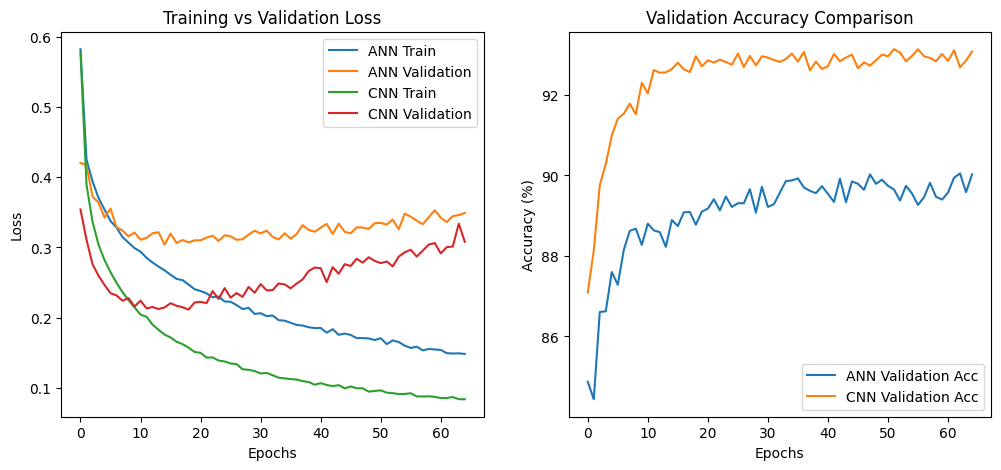


Test Results - ANN
Test Loss: 0.3724 | Test Accuracy: 89.32%


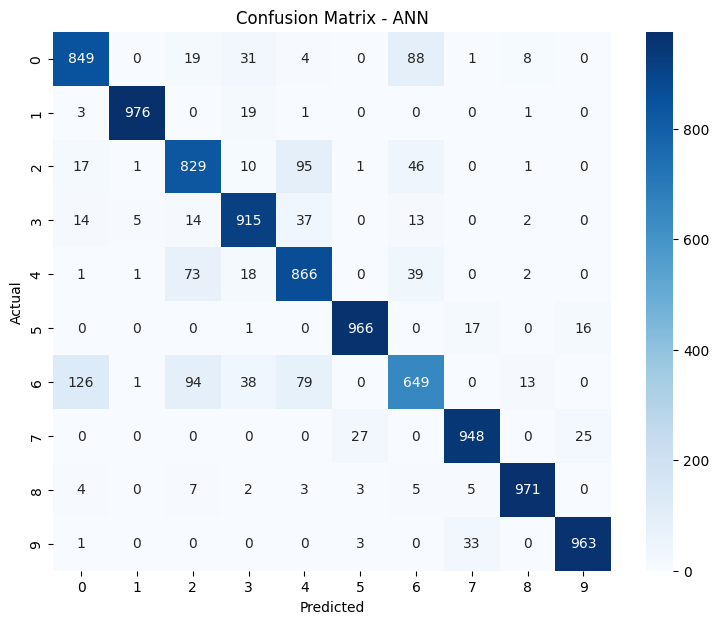


Test Results - CNN
Test Loss: 0.3475 | Test Accuracy: 92.23%


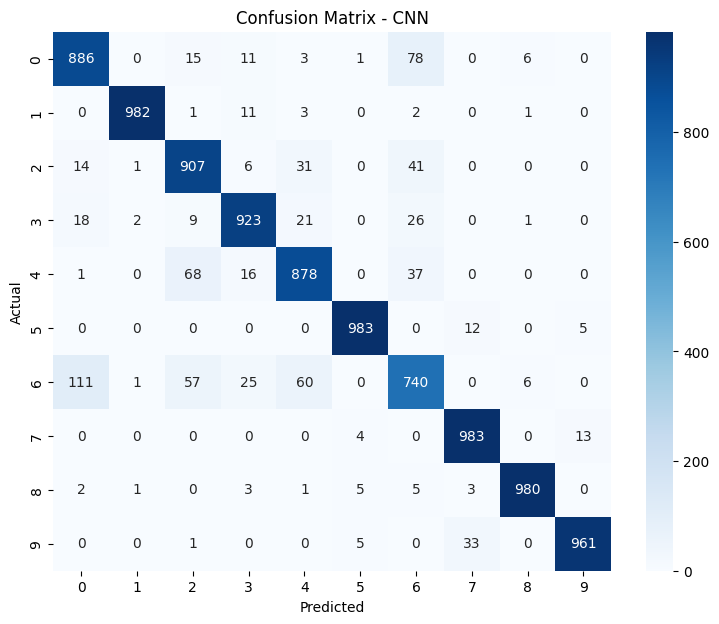


Summary -> ANN: Loss=0.3724, Acc=89.32% | CNN: Loss=0.3475, Acc=92.23%

Sample Predictions from CNN:


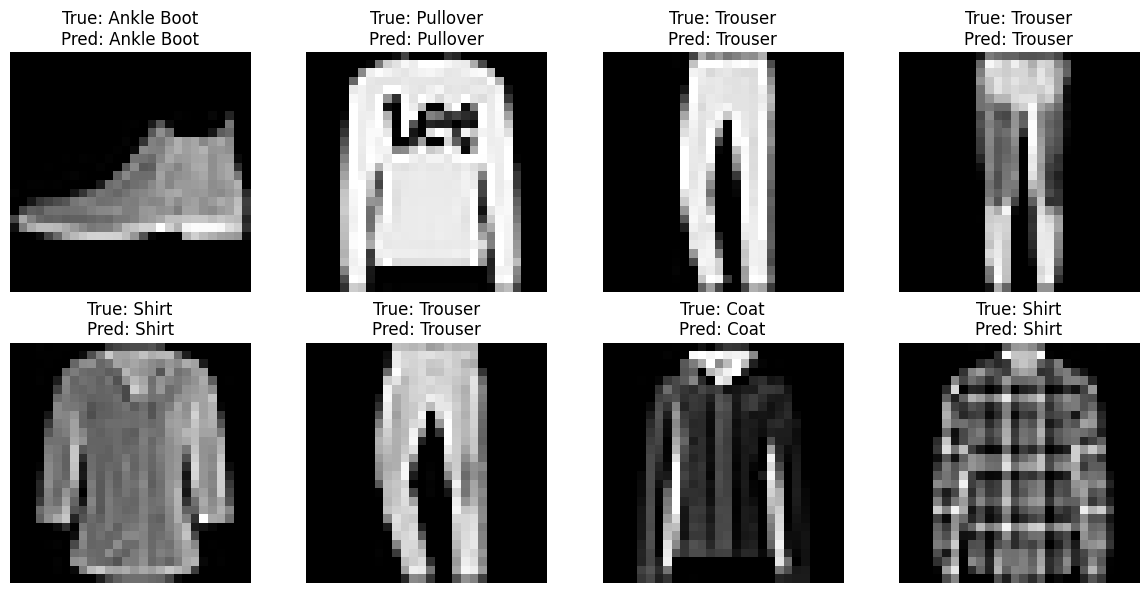

In [2]:

# 1️ IMPORT LIBRARIES
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


# 2️ LOAD AND PREPROCESS DATA

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))   # Normalize to [-1, 1]
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Split training data into 80% train / 20% validation
train_size = int(0.8 * len(train_dataset))
val_size   = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']


# 3️ DEFINE ANN MODEL

class ANN_Model(nn.Module):
    def __init__(self):
        super(ANN_Model, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten 28x28 image
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x


# 4️ DEFINE CNN MODEL

class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout_conv = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Corrected after 2 pooling layers
        self.fc_dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # 28x28 → 14x14
        x = self.pool(self.relu(self.conv2(x)))  # 14x14 → 7x7
        x = self.dropout_conv(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc_dropout(x)
        x = self.fc2(x)
        return x

# 5️ TRAINING FUNCTION

def train_model(model, train_loader, val_loader, epochs=65):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses, val_losses, val_acc = [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        # Validation phase
        model.eval()
        correct, total, val_loss = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        train_losses.append(running_loss / len(train_loader.dataset))
        val_losses.append(val_loss / len(val_loader.dataset))
        val_acc.append(acc)

        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Loss: {train_losses[-1]:.4f} | "
              f"Val Loss: {val_losses[-1]:.4f} | "
              f"Val Acc: {acc:.2f}%")

    return train_losses, val_losses, val_acc


# 6️ TRAIN BOTH MODELS

ann_model = ANN_Model().to(device)
cnn_model = CNN_Model().to(device)

print("\nTraining ANN Model...")
ann_train_loss, ann_val_loss, ann_val_acc = train_model(ann_model, train_loader, val_loader, epochs=65)

print("\nTraining CNN Model...")
cnn_train_loss, cnn_val_loss, cnn_val_acc = train_model(cnn_model, train_loader, val_loader, epochs=65)


# 7️ PLOT LOSS AND ACCURACY CURVES

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(ann_train_loss, label='ANN Train')
plt.plot(ann_val_loss, label='ANN Validation')
plt.plot(cnn_train_loss, label='CNN Train')
plt.plot(cnn_val_loss, label='CNN Validation')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(ann_val_acc, label='ANN Validation Acc')
plt.plot(cnn_val_acc, label='CNN Validation Acc')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


# 8️ EVALUATE ON TEST DATA

def test_model(model, test_loader, model_name):
    model.eval()
    criterion = nn.CrossEntropyLoss()  # Added for test loss
    correct, total, test_loss = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)  # Compute loss
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader.dataset)
    acc = 100 * correct / total

    print(f"\nTest Results - {model_name}")
    print(f"Test Loss: {avg_test_loss:.4f} | Test Accuracy: {acc:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(9,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return avg_test_loss, acc

ann_loss, ann_acc = test_model(ann_model, test_loader, "ANN")
cnn_loss, cnn_acc = test_model(cnn_model, test_loader, "CNN")

print(f"\nSummary -> ANN: Loss={ann_loss:.4f}, Acc={ann_acc:.2f}% | "
      f"CNN: Loss={cnn_loss:.4f}, Acc={cnn_acc:.2f}%")


# 9️ VISUALIZE SOME PREDICTIONS

def show_predictions(model):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(12,6))
    for i in range(8):
        plt.subplot(2,4,i+1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title(f"True: {classes[labels[i]]}\nPred: {classes[preds[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\nSample Predictions from CNN:")
show_predictions(cnn_model)

#  END
